# F/T sensor calibration repair and test

In [1]:
# packages needed for this tutorial
from pathlib import Path
from tqdm.notebook import trange

# math and robotics
import numpy as np
import quaternion
import spatialmath as sm
from scipy import optimize

# plotting 
import seaborn as sns
import matplotlib.pylab as plt

# ROS
import rospy

# hrr-cobot packages
import hrr_cobot_robot
import hrr_common
import hrr_controllers

# set printing and plotting options    
np.set_printoptions(precision=5, suppress=True)
sns.set_theme('notebook')
# %matplotlib notebook

In [2]:
hrr_common.utils.set_ros_environment(ros_master = 'localhost')

current hostname:	hrrcobotLinux54
current IP:      	129.187.147.74
ROS-MASTER-URI:  	http://127.0.0.1:11311


In [3]:
rospy.init_node("ft_calibration_debugger")

In [4]:
cobot = hrr_cobot_robot.HrrCobotControl.from_ros("/hrr_cobot", compile_numba=False)
print(cobot)

[rosout] [/ft_calibration_debugger] Initialize MATLAB-Motion planner @ /home/hrr_cobot/_ros/hr_recycler_ws/src/planner/src


[rosout] failed to initialize Matlab-connection due to: Unable to connect to MATLAB session 'MATLAB_177229'.


[rosout] current models are not compiled. Expect delays upon first call
Hrr-Cobot state:
FT-data:
current force:	[-20.92126   3.60254  15.32959] [N]
current torque:	[ -5.53137 -17.08197   1.13721] [Nm]
current wrench:	[-20.91508   3.621    15.32203  -5.52963 -17.10292   1.13272] [N,Nm]
=>in contact:	True
---
Robot-data:
q:		[  0.08061  -0.03687 -90.31063 184.77442 -84.00083 -35.35265][°]
q_dot:		[0. 0. 0. 0. 0. 0.][rad/s]
tau:		[0. 0. 0. 0. 0. 0.][Nm]
pos:		[ 0.44391 -0.00725  0.70383][m]
quat:		0.02452 <[ 0.95125 -0.3015   0.06015]>
tool-pos:	[ 0.44391 -0.00725  0.70383][m]
tool-rpy:	[ 35.41047   5.71963 175.21988][°]
robot-status:	ready
---


In [44]:
q_des = np.copy(cobot.q_calib)
q_des[-2]  -= 0.5
cobot.move_to_joint_pose(q_des)

[rosout] pose close to current (0.50 [rad]), use simple linear interpolation
[rosout] re-/deactivate controllers


In [18]:
cobot.Jac() @ np.r_[np.zeros(3), 1.0, 0., 0.0] * 1.0

array([-0.     , -0.05147, -0.02049, -1.     , -0.00043,  0.00124])

In [22]:
cobot._robot.J(cobot.q) @ np.r_[np.zeros(3), 1.0, 0., 0.0] * 1.0

array([ 0.00003, -0.07182,  0.02613, -0.99999,  0.00141,  0.00484])

In [23]:
limits = np.min(np.c_[np.pi * scale_max * np.ones(2), np.abs(cobot.q[q_i] - cobot.joint_limits)[q_i]], axis=1)
limits

array([0.31416, 0.00006])

## record data

In [33]:
def rotate_via_q(q_dot_max, direction, T, data=None):
    for i in trange(T):
        x_dot_ee = cobot.Jac() @ np.r_[np.zeros(3), direction] * q_dot_max * np.sin(2 * i * np.pi / T)
        cobot.update(u_cmd=x_dot_ee, u_cmd_frame=cobot.base_link, sleep=True)
        try:
            data.add(np.copy(cobot._ft_handle.wrench), cobot.FK(q), self.q)
        except AttributeError:
            pass
    cobot.stop()
    
def check_joint(q_i, q_dot_max, scale_max=1.0, data=None):
    assert 3<= q_i < 6, "roation limited to last three joints"
    limits = np.min(np.c_[np.pi * scale_max * np.ones(2), np.abs(cobot.q[q_i] - cobot.joint_limits)[q_i]], axis=1)
    select_joints = np.eye(3)
    for i, limit in enumerate(limits):
        direction = -1 if i == 0 else 1
        rotate_via_q(direction=select_joints[q_i - 3] * direction, 
                     T=int(limit * cobot.hz / q_dot_max),
                     q_dot_max=q_dot_max,
                     data=data)

In [41]:
# rotate repair
q_i = 4
select_joints = np.eye(3)
scale_max = 0.2
q_dot_max = 1.0
limits = np.min(np.c_[np.pi * scale_max * np.ones(2), np.abs(cobot.q[q_i] - cobot.joint_limits)[q_i]], axis=1)
T=int(limits[0] * cobot.hz / q_dot_max)
T, limits

(62, array([0.62832, 0.61889]))

In [42]:
cobot.stop()
cobot.init_sns_vel()
rotate_via_q(direction=select_joints[q_i - 3] * -1, T=int(limits[0] * cobot.hz / q_dot_max),
             q_dot_max=q_dot_max)
cobot.stop()
rospy.sleep(0.1)
rotate_via_q(direction=select_joints[q_i - 3], T=int(limits[1] * cobot.hz / q_dot_max),
             q_dot_max=q_dot_max)

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

In [46]:
cobot.init_sns_vel()

[rosout] current configuration close to current (0.00 [milli-rad]). keep pose


In [47]:
check_joint(3, 0.4)
check_joint(4, 0.2, scale_max=0.9)
check_joint(5, 0.4, scale_max=1.5)

  0%|          | 0/785 [00:00<?, ?it/s]

  0%|          | 0/785 [00:00<?, ?it/s]

  0%|          | 0/1413 [00:00<?, ?it/s]

  0%|          | 0/558 [00:00<?, ?it/s]

  0%|          | 0/1178 [00:00<?, ?it/s]

  0%|          | 0/1178 [00:00<?, ?it/s]

In [24]:
cobot.stop()

In [5]:
data = cobot.collect_calibration_data()

[rosout]could not reach motion planner. Use linear interpolation instead
pybullet build time: May  8 2021 05:48:13


Mujoco not found on this client. Do not use this file!
Mujoco not found on this client. Do not use this file!
current implementation does not cope with trees with edge degree over 1. Select first element from: ee_linkconnect_flange_attach_joint, ee_to_tcp  


In [6]:
# np.save('new_calib_routine.npy', data)

In [22]:
from hrr_common.utils import load_pickle
data2 = np.load('/tmp/calib01.npy', allow_pickle=True).item()
try:
    F_full_msr = np.vstack([x.wrench for x in data2]) if isinstance(data2, (list, tuple)) else data2.wrench
except AttributeError:
    data2 = data2.all_data
    F_full_msr = data2.wrench

R_B_E = np.vstack([x.R for x in data]) if isinstance(data2, (list, tuple)) else data2.R
R_FT_B = np.einsum('ij, dkj -> dik', R_FT_E, R_B_E)  # equals:  R_FT_E @ R_B_E.T in batched manner
parameters = load_pickle("/tmp/screwdriver.pkl")  # type: CalibrationParameters
B_grav = parameters.B_grav_vec
FT_com = parameters.FT_com
bias = parameters.bias

(<Figure size 720x1440 with 3 Axes>,
 array([<AxesSubplot:title={'center':'Force regression results'}>, <AxesSubplot:title={'center':'Torque regression results'}>, <AxesSubplot:title={'center':'Residuals after calibration'}>], dtype=object))

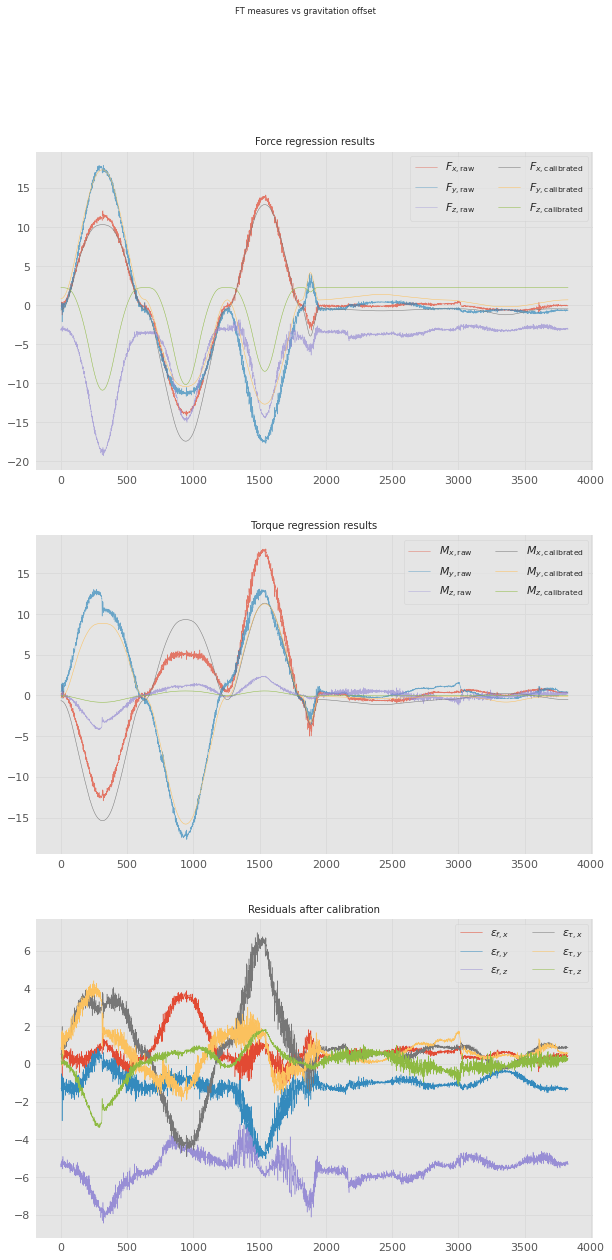

In [23]:
F_full_msr 
F_c = R_FT_B @ B_grav + bias[None, 0:3]
M_c = np.cross(FT_com, R_FT_B @ B_grav)+ bias[None, 3:6]
figsize=(10,20)
plot_calibration()

In [36]:
# md.jacobian(cobot.q) @ np.r_[np.zeros(4), -1.0, 0.0] * q_dot_max
np.rad2deg(cobot.q)

array([ -0.04759,  -0.12929, -90.09112,   0.26131,  88.50843,   0.0043 ])

In [39]:
np.rad2deg(cobot.q)

array([  -0.05917,  -11.59941, -105.07112,    0.35197,   56.1133 ,   -0.20475])

In [42]:
md.jacobian(cobot.q) @ np.r_[np.zeros(4), -1.0, 0.0] * q_dot_max 

array([ 0.0069 ,  0.00003,  0.00405,  0.00014, -0.1    ,  0.00061])

(1570, array([1.5708, 1.5708]))

In [101]:
check_joint(3, 0.4)
check_joint(4, 0.2, scale_max=0.9)
check_joint(5, 0.4, scale_max=1.5)

  0%|          | 0/785 [00:00<?, ?it/s]

  0%|          | 0/785 [00:00<?, ?it/s]

  0%|          | 0/1413 [00:00<?, ?it/s]

  0%|          | 0/324 [00:00<?, ?it/s]

  0%|          | 0/1178 [00:00<?, ?it/s]

  0%|          | 0/1178 [00:00<?, ?it/s]

In [ ]:
def rotate_q(q_i, q_dot_max=0.1):
    
    q_limits = cobot.q[q_i] - md.joint_limits
    T1, T2 = np.min(np.c_[np.pi * np.ones(2), 
                     (cobot.q[4] - md.joint_limits)[4]],
                    axis=1)
    if np.all(q_limits >= np.pi/2.0):
        T = 
    

In [91]:
T = int(np.pi * cobot.hz / q_dot_max)
T = int(0.627 * cobot.hz / q_dot_max)
q_dot_max = 0.1
rotate_via_q(T=T,q_dot_max=0.1, direction=np.r_[0.0, 1.0, 0.0])

  0%|          | 0/627 [00:00<?, ?it/s]

In [64]:
for i in range(T):
    x_dot_ee = md.jacobian(cobot.q) @ np.r_[np.zeros(3), 1.0, 0.0, 0.0] * q_dot_max * np.sin(2 * i * np.pi / T)
    cobot.update(u_cmd=x_dot_ee, u_cmd_frame=cobot.ee_link, sleep=True)
for i in range(T):
    x_dot_ee = md.jacobian(cobot.q) @ np.r_[np.zeros(3), -1.0, 0.0, 0.0] * q_dot_max * np.sin(2 * i * np.pi / T)
    cobot.update(u_cmd=x_dot_ee, u_cmd_frame=cobot.ee_link, sleep=True)
cobot.stop()

In [61]:
 np.pi * cobot.hz / q_dot_max

3141.592653589793

In [77]:
q_i = 3
q_dot_max = 0.2
T1, T2 = np.min(np.c_[np.pi * np.ones(2), 
                     np.abs(cobot.q[q_i] - md.joint_limits)[q_i]],
                    axis=1)
for direction, limit in zip((-1, 1), (T1, T2)):
    T = int(limit * cobot.hz / q_dot_max)
    for i in range(T):
        x_dot_ee = md.jacobian(cobot.q) @ np.r_[np.zeros(3), direction, 0.0, 0.0] * q_dot_max * np.sin(2 * i * np.pi / T)
        cobot.update(u_cmd=x_dot_ee, u_cmd_frame=cobot.ee_link, sleep=True)

In [89]:
q_i = 4
np.min(np.c_[np.pi * np.ones(2), 
                     np.abs(cobot.q[q_i] - md.joint_limits)[q_i]],
                    axis=1)

array([3.14159, 0.62804])

In [50]:
cobot.init_sns_vel()

In [2]:
data = np.load('./new_calib_routine.npy', allow_pickle=True).item()

## manual regression

In [1]:
def manual_freespace_offset_regression(data, R_FT_E, figsize=(8, 10), plot=False, call_plot=False):

    def F_grav(θ):
        return R_FT_B @ θ[0:3] + θ[3:6][None, :] 

    def M_grav(θ):
        return np.cross(θ[0:3], R_FT_B @ B_grav_vec) + θ[3:6][None, :]

    def J_F(θ):
        return np.linalg.norm(F_grav(θ) - F_full_msr[:, 0:3], axis=-1)

    def J_M(θ):
        return np.linalg.norm(M_grav(θ) - F_full_msr[:, 3:6], axis=-1)


    def J_all(θ):
        F_avg = np.mean(F_full_msr, axis=0)
        F = R_FT_B @ θ[0:3] + θ[6:9][None, :] + F_avg[0:3]
        M = np.cross(θ[3:6], R_FT_B @ θ[0:3]) + θ[9:12][None, :] + F_avg[3:6]
        return np.linalg.norm(F - F_full_msr[:, 0:3], axis=-1) +\
               np.linalg.norm(M - F_full_msr[:, 3:6], axis=-1)


    def plot_calibration():
        fig, axs = plt.subplots(3, 1, figsize=figsize)
        fig.suptitle("FT measures vs gravitation offset")

        axs[0].plot(F_full_msr[:, 0:3], alpha=0.7)
        axs[0].plot(F_c)
        axs[0].legend(
            [f"$F_{{{x}, \\mathrm{{raw}}}}$" for x in ("x", "y", "z")] +
            [f"$F_{{{x}, \\mathrm{{calibrated}}}}$" for x in ("x", "y", "z")],
            ncol=2)
        axs[0].set_title(f'Force regression results')

        axs[1].plot(F_full_msr[:, 3:6], alpha=0.7)
        axs[1].plot(M_c)
        axs[1].legend(
            [f"$M_{{{x}, \\mathrm{{raw}}}}$" for x in ("x", "y", "z")] +
            [f"$M_{{{x}, \\mathrm{{calibrated}}}}$" for x in ("x", "y", "z")],
            ncol=2)
        axs[1].set_title(f'Torque regression results')

        axs[2].plot(F_full_msr[:, 0:3] - F_c)
        axs[2].plot(F_full_msr[:, 3:6] - M_c)
        axs[2].legend(
            [f"$\\varepsilon_{{f, {x}}}$" for x in ("x", "y", "z")] +
            [f"$\\varepsilon_{{\\tau, {x}}}$" for x in ("x", "y", "z")],
            ncol=2
        )
        axs[2].set_title(f'Residuals after calibration')
        return fig, axs
    
    F_full_msr = np.vstack([x.wrench for x in data]) if isinstance(data, (list, tuple)) else data.wrench
    R_B_E = np.vstack([x.R for x in data]) if isinstance(data, (list, tuple)) else data.R    
    F_avg = 0.0 * np.mean(F_full_msr, axis=0)
    F_full_msr -= F_avg
    R_FT_B = np.einsum('ij, dkj -> dik', R_FT_E, R_B_E)
    bias = np.mean(F_full_msr, axis=0)
    bias[2] *= 0.0
    noise = np.zeros(6)

    rospy.logdebug("Starting Calibration Regression...")
    # force measure regression
    F_calib = optimize.least_squares(J_F, np.r_[np.zeros(2), 1.0, bias[0:3]], gtol=1e-11, xtol=1e-11, ftol=1e-10)
    if not F_calib.success:
        rospy.logwarn(f"could not derive calibration for force-measures: {F_calib.message}")
    B_grav_vec = F_calib.x[0:3]
    bias[0:3] = F_calib.x[3:6]
    F_c = F_grav(np.r_[B_grav_vec, bias[0:3]])
    noise[:3] = np.std(F_full_msr[:, 0:3] - F_c, axis=0)

    # torque measure regression
    M_calib = optimize.least_squares(J_M, np.r_[np.zeros(2), 1e-2, bias[3:6]], gtol=1e-11, xtol=1e-11, ftol=1e-8)
    if not M_calib.success:
        rospy.logwarn(f"could not derive calibration for torque-measures: {M_calib.message}")
    com = M_calib.x[0:3]
    bias[3:6] = M_calib.x[3:6]
    M_c = M_grav(np.r_[com, bias[3:6]])
    noise[3:6] = np.std(F_full_msr[:, 3:6] - M_c, axis=0)
    rospy.logdebug("... finished calibration process")
    if plot:
        f, a = plot_calibration()
        if call_plot:
            plt.show()
        return B_grav_vec, bias, com, noise, dict(fig=f, axs=a)
    return B_grav_vec, bias + F_avg, com, noise, dict()

In [18]:
wsg_data = np.load('/home/hrr_cobot/Documents/skill_recordings/wsg_50_dsa_calibration.npy', allow_pickle=True).item()

could not derive calibration for torque-measures: The maximum number of function evaluations is exceeded.


(array([  0.20162,   0.39297, -24.44241]),
 array([ -6.00452,   5.64447, -18.62756,  -3.81811,  -6.83559,  -0.83845]),
 array([-0.0697 , -0.08314,  0.97482]),
 array([1.54837, 1.30515, 1.4959 , 2.46553, 2.22622, 0.89389]),
 {'fig': <Figure size 576x720 with 3 Axes>,
  'axs': array([<AxesSubplot:title={'center':'Force regression results'}>,
         <AxesSubplot:title={'center':'Torque regression results'}>,
         <AxesSubplot:title={'center':'Residuals after calibration'}>],
        dtype=object)})

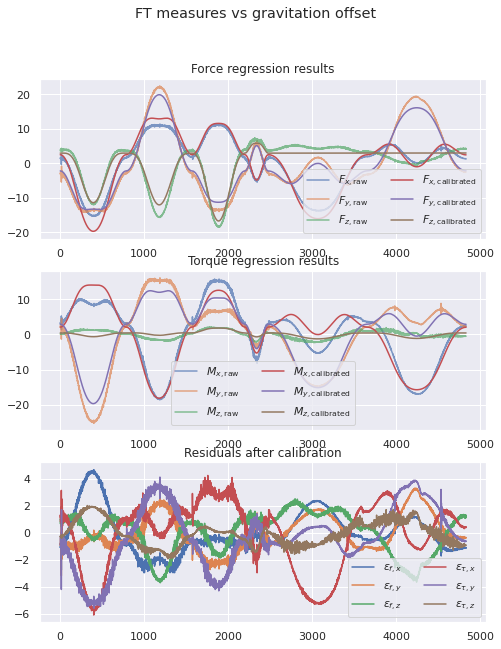

In [33]:
# %matplotlib notebook
R_FT_E = sm.base.rotz(-45, "deg")
manual_freespace_offset_regression(wsg_data, R_FT_E , plot=True)

could not derive calibration for torque-measures: The maximum number of function evaluations is exceeded.


[1.54837 1.30515 1.4959  2.46553 2.22622 0.89388]


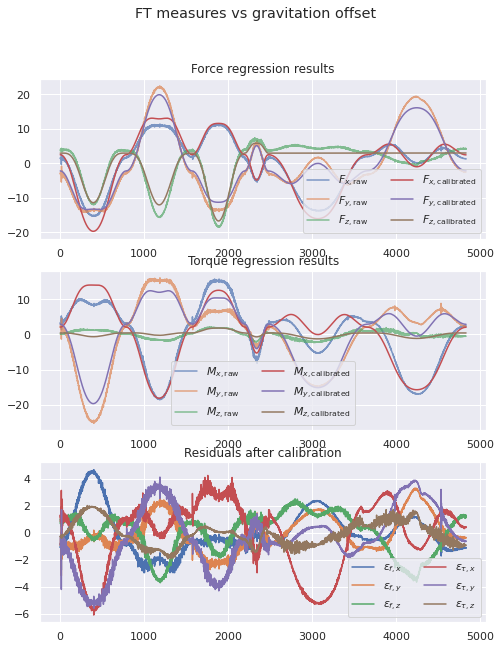

In [34]:
X, _ = hrr_controllers.freespace_offset_regression(wsg_data, R_FT_E, plot=True)
print(X.noise)

In [25]:
X

CalibrationParameters(bias=array([ -6.00452,   5.64447, -18.62756,  -3.81811,  -6.83558,  -0.83845]), noise=array([1.54837, 1.30515, 1.4959 , 2.46553, 2.22621, 0.89388]), B_grav_vec=array([  0.20162,   0.39297, -24.44241]), FT_com=array([-0.0697 , -0.08314,  0.97482]))

In [26]:
def F_grav():
        return 

def M_grav(θ):
    return 

F_full = wsg_data.wrench
R_FT_B = np.einsum('ij, dkj -> dik', R_FT_E, wsg_data.R)
F = R_FT_B @ X.B_grav_vec + X.bias[None, 0:3] 
M = np.cross(X.FT_com, R_FT_B @ X.B_grav_vec) + X.bias[None, 3:6] 

array([1.54837, 1.30515, 1.4959 , 2.46553, 2.22621, 0.89388])

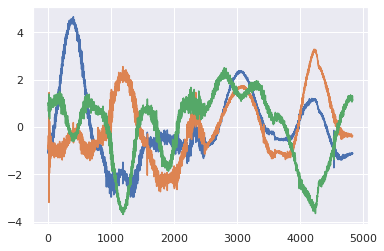

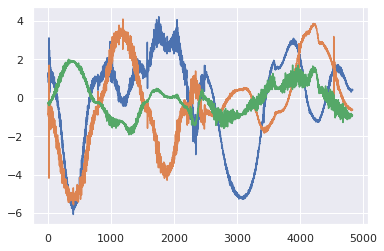

In [32]:
err_F = F_full[:, 0:3] - F
err_M = F_full[:, 3:6] - M
plt.figure()
plt.plot(err_F)
plt.figure()
plt.plot(err_M)
np.r_[np.std(err_F, axis=0), np.std(err_M, axis=0)]

In [27]:
F.shape

(4833, 3)

In [ ]:
params = np.load('/tmp/screwdriver.pkl')

In [8]:
R_FT_E = sm.base.rotz(-45, "deg")
R_FT_E, cobot.R_FT_E

(array([[ 0.70711,  0.70711,  0.     ],
        [-0.70711,  0.70711,  0.     ],
        [ 0.     ,  0.     ,  1.     ]]),
 array([[ 0.70711,  0.70711,  0.     ],
        [-0.70711,  0.70711,  0.     ],
        [ 0.     ,  0.     ,  1.     ]]))

In [17]:
def F_grav(θ):
    return R_FT_B @ θ[0:3] + θ[3:6][None, :] 

def M_grav(θ):
    return np.cross(θ[0:3], R_FT_B @ B_grav_vec) + θ[3:6][None, :]

def J_F(θ):
    return np.linalg.norm(F_grav(θ) - F_full_msr[:, 0:3], axis=-1)

def J_M(θ):
    return np.linalg.norm(M_grav(θ) - F_full_msr[:, 3:6], axis=-1)


def J_all(θ):
    F_avg = np.mean(F_full_msr, axis=0)
    F = R_FT_B @ θ[0:3] + θ[6:9][None, :] + F_avg[0:3]
    M = np.cross(θ[3:6], R_FT_B @ θ[0:3]) + θ[9:12][None, :] + F_avg[3:6]
    return np.linalg.norm(F - F_full_msr[:, 0:3], axis=-1) +\
           np.linalg.norm(M - F_full_msr[:, 3:6], axis=-1)


def plot_calibration():
    fig, axs = plt.subplots(3, 1, figsize=figsize)
    fig.suptitle("FT measures vs gravitation offset")

    axs[0].plot(F_full_msr[:, 0:3], alpha=0.7)
    axs[0].plot(F_c)
    axs[0].legend(
        [f"$F_{{{x}, \\mathrm{{raw}}}}$" for x in ("x", "y", "z")] +
        [f"$F_{{{x}, \\mathrm{{calibrated}}}}$" for x in ("x", "y", "z")],
        ncol=2)
    axs[0].set_title(f'Force regression results')

    axs[1].plot(F_full_msr[:, 3:6], alpha=0.7)
    axs[1].plot(M_c)
    axs[1].legend(
        [f"$M_{{{x}, \\mathrm{{raw}}}}$" for x in ("x", "y", "z")] +
        [f"$M_{{{x}, \\mathrm{{calibrated}}}}$" for x in ("x", "y", "z")],
        ncol=2)
    axs[1].set_title(f'Torque regression results')

    axs[2].plot(F_full_msr[:, 0:3] - F_c)
    axs[2].plot(F_full_msr[:, 3:6] - M_c)
    axs[2].legend(
        [f"$\\varepsilon_{{f, {x}}}$" for x in ("x", "y", "z")] +
        [f"$\\varepsilon_{{\\tau, {x}}}$" for x in ("x", "y", "z")],
        ncol=2
    )
    axs[2].set_title(f'Residuals after calibration')
    return fig, axs


In [9]:
# R_FT_E = cobot.R_FT_E,

F_full_msr = np.vstack([x.wrench for x in data])
F_avg = np.mean(F_full_msr, axis=0)
F_full_msr -= F_avg
R_FT_B = np.einsum('ij, dkj -> dik', R_FT_E, np.vstack([x.R for x in data]))
bias = np.mean(F_full_msr, axis=0)
noise = np.zeros(6)

rospy.logdebug("Starting Calibration Regression...")
# force measure regression
F_calib = optimize.least_squares(J_F, np.r_[np.zeros(2), 1.0, bias[0:3]], gtol=1e-11, xtol=1e-11, ftol=1e-8)
if not F_calib.success:
    rospy.logwarn(f"could not derive calibration for force-measures: {F_calib.message}")
B_grav_vec = F_calib.x[0:3]
bias[0:3] = F_calib.x[3:6]
F_c = F_grav(np.r_[B_grav_vec, bias[0:3]])
noise[:3] = np.std(F_full_msr[:, 0:3] - F_c, axis=0)

# torque measure regression
M_calib = optimize.least_squares(J_M, np.r_[np.zeros(2), 1e-2, bias[3:6]], gtol=1e-11, xtol=1e-11, ftol=1e-6)
if not M_calib.success:
    rospy.logwarn(f"could not derive calibration for torque-measures: {M_calib.message}")
com = M_calib.x[0:3]
bias[3:6] = M_calib.x[3:6]
M_c = M_grav(np.r_[com, bias[3:6]])
noise[3:6] = np.std(F_full_msr[:, 3:6] - M_c, axis=0)
rospy.logdebug("... finished calibration process")

TypeError: 'CalibDataFull' object is not iterable

In [ ]:
plot_calibration()

## test implemented regression

In [10]:
from hrr_controllers.sensor_handles import freespace_offset_regression

In [ ]:
freespace_offset_regression(data, cobot.R_FT_E, plot=True, figsize=(10, 10))